## Quadrocopter Programming

We are testing a tracking program and we evaluate it with the help of a quadrocopter. The quadrocopter sends estimates of its velocity and the tracking program estimates its global position with respect to the quadrocopter's initial position (before flying).

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.linalg as LA
from mpl_toolkits.mplot3d import Axes3D

np.set_printoptions(precision=4)

**a)** The tracker yields these tracked position estimates at a frequency of $1Hz$:

In [3]:
positions = np.array([[2, 0, 1],
                      [1.08, 1.68, 2.38],
                      [-0.83, 1.82, 2.49],
                      [-1.97, 0.28, 2.15],
                      [-1.31, -1.51, 2.59],
                      [0.57, -1.91, 4.32]])
positions

array([[ 2.  ,  0.  ,  1.  ],
       [ 1.08,  1.68,  2.38],
       [-0.83,  1.82,  2.49],
       [-1.97,  0.28,  2.15],
       [-1.31, -1.51,  2.59],
       [ 0.57, -1.91,  4.32]])

Plot the trajectory through these data points with your tool of choice.

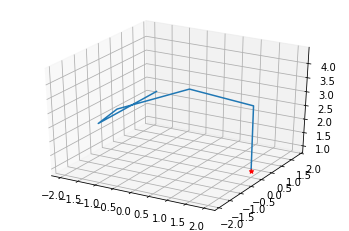

In [4]:
## plot trajectory
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot(xs=positions[:, 0], ys=positions[:, 1], zs=positions[:, 2])
ax.scatter(positions[0, 0], positions[0, 1], positions[0, 2], c='r', marker='*')

**b)**  Assuming the quadrocopter flies with constant speed, what speed does it have?
  What is the residual error of the estimation?

*Hint for b) and c): Use the Polynomial Regression method introduced in the lecture.*

Constant velocity model means: $x(t) = w_{x,0} + t \cdot w_{x,1}$. The same holds for $y(t)$ and $z(t)$. Therefore:

$$ \begin{bmatrix} x(t) & y(t) & z(t) \end{bmatrix} = \begin{bmatrix} 1 & t \end{bmatrix} 
\begin{bmatrix} w_{x,0} & w_{y,0} & w_{z,0} \\ w_{x,1} & w_{y,1} & w_{z,1} \end{bmatrix} = \Phi \mathbf{w}
$$


Namely, the timesteps are our features. Our feature matrix $\Phi \in \mathbb{R}^{N \times 2}$ has the form:

$$ \Phi = \begin{bmatrix} 1 & 1 \\ 1 & 2 \\ \ldots & \ldots \\ 1 & T \end{bmatrix}  $$

In [5]:
time_steps = np.arange(len(positions))
Phi = np.column_stack([np.ones(len(positions)), time_steps])
Phi

array([[1., 0.],
       [1., 1.],
       [1., 2.],
       [1., 3.],
       [1., 4.],
       [1., 5.]])

We compute the pseudo-inverse $ \Phi^\dagger = (\Phi^T \Phi)^{-1} \Phi^T $

In [6]:
# compute pseudo-inverse
# Phi_pi = LA.inv(Phi.T.dot(Phi)).dot(Phi.T)
Phi_pinv = LA.pinv2(Phi)
Phi_pinv

array([[ 0.5238,  0.381 ,  0.2381,  0.0952, -0.0476, -0.1905],
       [-0.1429, -0.0857, -0.0286,  0.0286,  0.0857,  0.1429]])

Finally, we can compute the model weights using $$ \mathbf{w} = \Phi^\dagger \mathbf{t}, $$ where $\mathbf{t}$, the groundtruth labels are the positions in our case.

In [7]:
weights = np.dot(Phi_pinv, positions)
weights

array([[ 1.0276,  1.5357,  1.2819],
       [-0.4417, -0.5903,  0.4826]])

From the model definition, it is easy to see that the second row of $\mathbf{w}$ corresponds to the speed for each axis:

$$ \begin{bmatrix} v_x & v_y & v_z \end{bmatrix} = \begin{bmatrix} w_{x,1} & w_{y,1} & w_{z,1} \end{bmatrix} $$

In [8]:
v = weights[1]
v

array([-0.4417, -0.5903,  0.4826])

The residuals are the deviations of the predicted values from the empirical values of data. 

To compute the residuals, let us first compute the model's predictions on the training data:

In [9]:
y_pred = np.dot(Phi, weights)
y_pred

array([[ 1.0276,  1.5357,  1.2819],
       [ 0.5859,  0.9454,  1.7645],
       [ 0.1442,  0.3551,  2.247 ],
       [-0.2975, -0.2351,  2.7296],
       [-0.7392, -0.8254,  3.2122],
       [-1.181 , -1.4157,  3.6948]])

Then we can compute the norm of the residuals for each axis:

In [10]:
residuals = np.linalg.norm(positions - y_pred, axis=0)
residuals

array([2.8857, 2.454 , 1.2773])

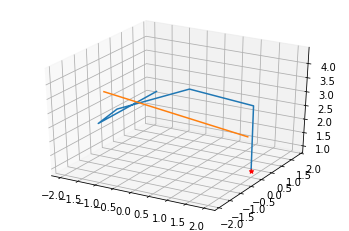

In [11]:
## plot trajectory
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot(xs=positions[:, 0], ys=positions[:, 1], zs=positions[:, 2])
ax.plot(xs=y_pred[:, 0], ys=y_pred[:, 1], zs=y_pred[:, 2])
ax.scatter(positions[0, 0], positions[0, 1], positions[0, 2], c='r', marker='*')

**c)** Now assume that the quadrocopter flies with constant acceleration. What is the residual error now? Is the error higher or lower? Why?

The only thing that changes from question (b) is that the model is now: $x(t) = w_{x,0} + t \cdot w_{x,1} + t^2 \cdot w_{x,2}$. 

Namely we have an additional row in $\mathbf{w}$ (an additional weight for each axis).

Accordingly, we have an additional column in $\Phi$:

$$ \Phi = \begin{bmatrix} 1 & 1 & 1 \\ 1 & 2 & 4\\ \ldots & \ldots & \ldots \\ 1 & T & T^2 \end{bmatrix}  $$

In [12]:
Phi = np.column_stack([np.ones(len(positions)), time_steps, time_steps**2])
Phi

array([[ 1.,  0.,  0.],
       [ 1.,  1.,  1.],
       [ 1.,  2.,  4.],
       [ 1.,  3.,  9.],
       [ 1.,  4., 16.],
       [ 1.,  5., 25.]])

In [13]:
Phi_pinv = LA.pinv2(Phi)
weights = np.dot(Phi_pinv, positions)
weights

array([[ 2.4729,  0.4571,  1.4646],
       [-2.6096,  1.0276,  0.2085],
       [ 0.4336, -0.3236,  0.0548]])

Now the second row of $\mathbf{w}$ corresponds to the speed and the third row to the acceleration for each axis.

In [14]:
y_pred2 = np.dot(Phi, weights)
y_pred2

array([[ 2.4729,  0.4571,  1.4646],
       [ 0.2969,  1.1611,  1.7279],
       [-1.012 ,  1.218 ,  2.1009],
       [-1.4537,  0.6277,  2.5834],
       [-1.0283, -0.6097,  3.1756],
       [ 0.2643, -2.4943,  3.8775]])

In [15]:
residuals = np.linalg.norm(positions - y_pred2, axis=0)
residuals

array([1.1443, 1.4538, 1.2325])

We added some complexity to the model (more weights). Therefore it is able to represent the position with a more complicated function takes acceleration into account. 

Thus, it is more accurate than the constant-speed-model.

**d)** According to our last model, what is the quadrocopter's most likely position in the next second?




In [16]:
t_new = 6
phi_new = np.array([[1., 6., 36.]])
phi_new

array([[ 1.,  6., 36.]])

In [17]:
y_new = np.dot(phi_new, weights)
y_new

array([[ 2.424, -5.026,  4.689]])

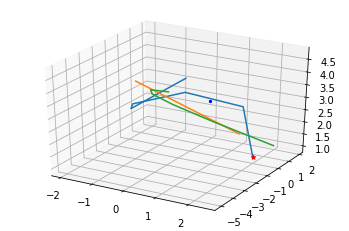

In [18]:
## plot trajectory
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot(xs=positions[:, 0], ys=positions[:, 1], zs=positions[:, 2])
ax.plot(xs=y_pred[:, 0], ys=y_pred[:, 1], zs=y_pred[:, 2])
ax.plot(xs=y_pred2[:, 0], ys=y_pred2[:, 1], zs=y_pred2[:, 2])
ax.scatter(positions[0, 0], positions[0, 1], positions[0, 2], c='r', marker='*')
ax.scatter(y_new[0, 0], y_new[0, 1], y_new[0, 2], c='b', marker='.')

Bonus: Lets choose a polynomial of degree 6

In [19]:

Phi = np.column_stack([np.ones_like(time_steps), time_steps, time_steps**2, time_steps**3, time_steps**4, time_steps**5, time_steps**6])
Phi_pinv = LA.pinv2(Phi)
weights = np.dot(Phi_pinv, positions)

steps = np.arange(0,len(positions),0.1)
Phi_new = np.column_stack([np.ones_like(steps), steps, steps**2, steps**3, steps**4, steps**5, steps**6])
y_pred6 = np.dot(Phi_new, weights)



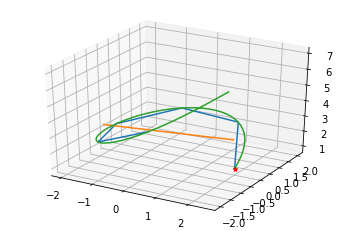

In [20]:
## plot trajectory
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot(xs=positions[:, 0], ys=positions[:, 1], zs=positions[:, 2])
ax.plot(xs=y_pred[:, 0], ys=y_pred[:, 1], zs=y_pred[:, 2])
ax.plot(xs=y_pred6[:, 0], ys=y_pred6[:, 1], zs=y_pred6[:, 2])
ax.scatter(positions[0, 0], positions[0, 1], positions[0, 2], c='r', marker='*')

In [21]:
residuals = np.linalg.norm(positions - y_pred6[::10], axis=0)
residuals

array([4.7924e-13, 3.9902e-12, 3.6960e-12])